In [1]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
%load_ext line_profiler

In [6]:
# L_list=np.arange(8,18,2)
L_list=np.arange(10,14,2)

In [4]:
# dirpath='Data/Bitstring'
dirpath='/home/jake/Data/Bitstring'

In [7]:
f_0={}
for L in L_list:
    f_0[L]=h5py.File(os.path.join(dirpath,f'CT_En2000_pctrl(0.00,1.00,21)_pproj(0.00,0.00,1)_L({L},{L+2},2)_xj(0)_seed0_64_wf.hdf5'))

In [15]:
def l1_coherence(rho,k,normalization=False,average=False):
    L=len(rho.shape)//2
    if k == 0:
        ket_idx=(0,)*L
    else:
        ket_idx=(0,)*(L-k)+(1,)+(slice(None),)*(k-1)

    bra_idx=(0,)*(L-k-1)+(1,)+(slice(None),)*(k)
    tr=trace(rho[ket_idx+ket_idx])+trace(rho[bra_idx+bra_idx])

    coh=np.abs(rho[ket_idx+bra_idx]).sum()

    if normalization:
        coh/=tr.real
    if average:
        coh/=np.prod(rho[ket_idx+bra_idx].shape)
    return coh




In [16]:
def trace(rho):
    L=len(rho.shape)
    if L>0:
        return np.einsum(rho,list(range(L//2))*2)
    else:
        return rho

In [17]:
def plot_coherence(rho,diag=False,ax=None,idx=(0,12)):
    if ax is None:
        fig,ax=plt.subplots()
    L=len(rho.shape)//2
    rho_abs=np.abs(rho).reshape((2**L,2**L))
    if diag:
        im=ax.imshow(rho_abs[idx[0]:idx[1],idx[0]:idx[1]])
    else:
        im=ax.imshow(rho_abs[idx[0]:idx[1],idx[0]:idx[1]]- np.diag(np.diag(rho_abs[idx[0]:idx[1],idx[0]:idx[1]])))
    axins=ax.inset_axes([1.05,0,0.05,1],transform=ax.transAxes)
    im=plt.colorbar(im,cax=axins,label=r'$|{\rho}|$')
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')


In [18]:
def get_rho_av(f_0,L,i):
    wf=f_0[L][f'wf_{L}'][i,0,0,...,:,0]
    rho_av=np.einsum(wf,np.r_[np.arange(0,L),2*L],np.conj(wf),np.r_[np.arange(L,2*L),2*L],np.arange(2*L))/f_0[L][f'wf_{L}'].shape[-2]
    return rho_av

In [16]:
rho_av=get_rho_av(f_0,8,0)

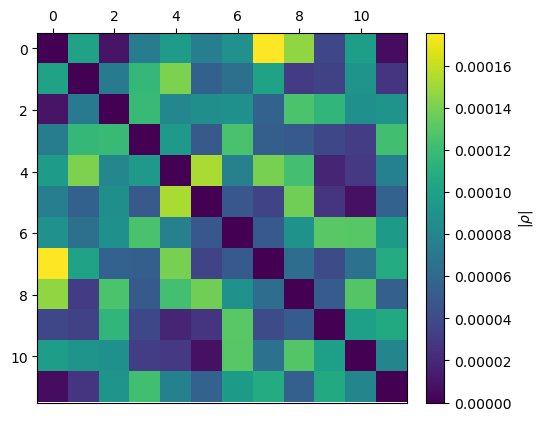

In [50]:
plot_coherence(rho_av,diag=False)

In [19]:
def l1_coherence_all(f_0,L,i,normalization=False,average=True):
    # wf=f_0[L][f'wf_{L}'][i,0,0,...,:,0]
    # dm_av=np.einsum(wf,np.r_[np.arange(0,L),2*L],np.conj(wf),np.r_[np.arange(L,2*L),2*L],np.arange(2*L))/f_0[L][f'wf_{L}'].shape[-2]

    rho_av=get_rho_av(f_0,L,i)
    
    return [l1_coherence(rho_av,k,normalization=normalization,average=average) for k in range(L)]

In [54]:
l1_coherence_all(f_0,L=8,i=0,normalization=True)

[0.013131993423792317,
 0.016200700609301462,
 0.027189298844675493,
 0.045647250896196916,
 0.1082025774614713,
 0.22065050694901078,
 0.4268802372429756,
 0.8443569274743464]

In [58]:
coh_map8=[l1_coherence_all(f_0,L=8,i=i,normalization=False,average=True) for i in range(21)]

In [60]:
coh_map10=[l1_coherence_all(f_0,L=10,i=i,normalization=False,average=True) for i in range(21)]

In [20]:
%lprun -f get_rho_av l1_coherence_all(f_0,L=10,i=0,normalization=False,average=True)

Timer unit: 1e-09 s

Total time: 4.66351 s
File: /tmp/ipykernel_775380/1750786917.py
Function: get_rho_av at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def get_rho_av(f_0,L,i):
     2         1   33728748.0    3e+07      0.7      wf=f_0[L][f'wf_{L}'][i,0,0,...,:,0]
     3         1 4629777839.0    5e+09     99.3      rho_av=np.einsum(wf,np.r_[np.arange(0,L),2*L],np.conj(wf),np.r_[np.arange(L,2*L),2*L],np.arange(2*L))/f_0[L][f'wf_{L}'].shape[-2]
     4         1        457.0    457.0      0.0      return rho_av

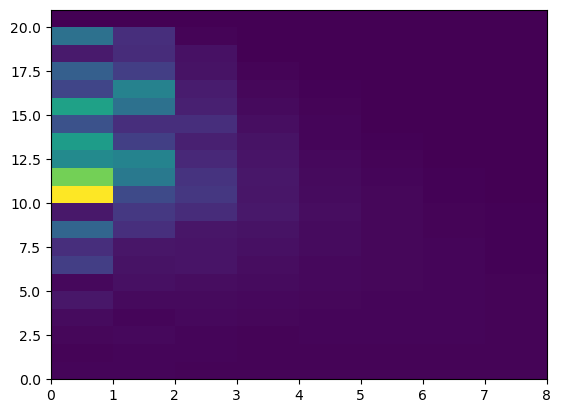

In [59]:
plt.pcolormesh(coh_map8)

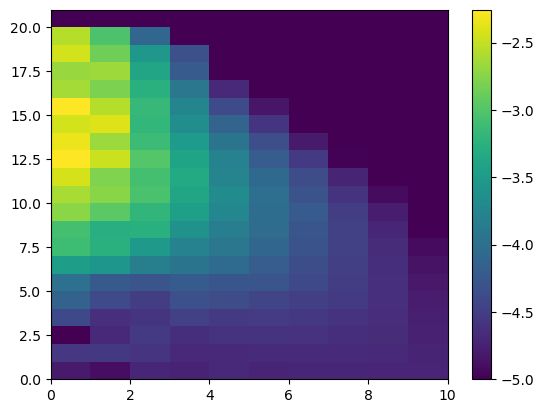

In [74]:
plt.pcolormesh(np.log10(np.array(coh_map10)+1e-10),vmin=-5,)
plt.colorbar()

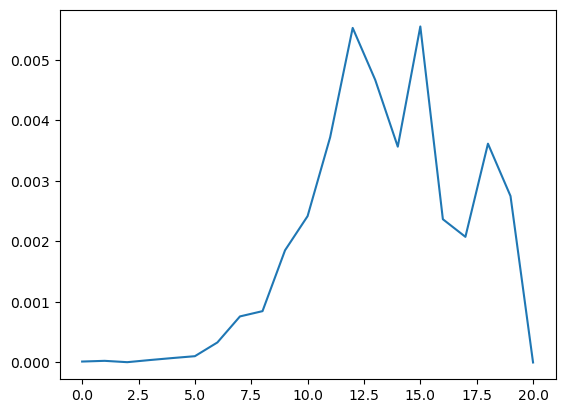

In [72]:
plt.plot(np.array(coh_map10)[:,0])